In [60]:
import pandas as pd
from pathlib import Path

base = Path("Datasets/MachineLearningCVE")  # adjust to your folder path

# gather all daily CSVs
csvs = list(base.glob("*.csv"))
print(f"Found {len(csvs)} CSV files")

data = []
for csv in csvs:
    df_data = pd.read_csv(csv)
    data.append(df_data)
    
all_data_raw = pd.concat(data, ignore_index=True)

Found 8 CSV files


In [43]:
print(all_data_raw.shape)
all_data_raw.info()

target_counts = all_data_raw[" Label"].value_counts()
print("Class Distribution:\n", target_counts)
print("\nClass Balance\n", target_counts/len(all_data_raw)*100)

(2830743, 79)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2830743 entries, 0 to 2830742
Data columns (total 79 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0    Destination Port             int64  
 1    Flow Duration                int64  
 2    Total Fwd Packets            int64  
 3    Total Backward Packets       int64  
 4   Total Length of Fwd Packets   int64  
 5    Total Length of Bwd Packets  int64  
 6    Fwd Packet Length Max        int64  
 7    Fwd Packet Length Min        int64  
 8    Fwd Packet Length Mean       float64
 9    Fwd Packet Length Std        float64
 10  Bwd Packet Length Max         int64  
 11   Bwd Packet Length Min        int64  
 12   Bwd Packet Length Mean       float64
 13   Bwd Packet Length Std        float64
 14  Flow Bytes/s                  float64
 15   Flow Packets/s               float64
 16   Flow IAT Mean                float64
 17   Flow IAT Std                 float64
 18   Flow IA

So the dataset is wildly skewed imbalanced towards benign packets, which is to be expected. I might want to ask Prof Flores about this during OH tomorrow.

For now, what I think would be best here would be to run some kind of feature correlation - find out which benign packets are similar to the malicious packets and train models using benign packets that are similar to mailicious ones. PROBLEM: I do not know what effect this will have on training, or if it is even necessary at all.

I also need to figure out how I want to tackle the ML model: right now, it might be best to do a binary classification - benign or malicious - and if the packet is malicious, find out what kind of attack may be at hand through a second model.

SMOTE to handle the imbalancing? Synthetic data to help remove imbalance on certain classes

Find features to detect attack

In [5]:
all_data_raw.describe()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,...,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06
mean,8.071483e+03,1.478566e+07,9.361160e+00,1.039377e+01,5.493024e+02,1.616264e+04,2.075999e+02,1.871366e+01,5.820194e+01,6.891013e+01,...,5.418218e+00,-2.741688e+03,8.155132e+04,4.113412e+04,1.531825e+05,5.829582e+04,8.316037e+06,5.038439e+05,8.695752e+06,7.920031e+06
std,1.828363e+04,3.365374e+07,7.496728e+02,9.973883e+02,9.993589e+03,2.263088e+06,7.171848e+02,6.033935e+01,1.860912e+02,2.811871e+02,...,6.364257e+02,1.084989e+06,6.485999e+05,3.933815e+05,1.025825e+06,5.770923e+05,2.363008e+07,4.602984e+06,2.436689e+07,2.336342e+07
min,0.000000e+00,-1.300000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,-5.368707e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.300000e+01,1.550000e+02,2.000000e+00,1.000000e+00,1.200000e+01,0.000000e+00,6.000000e+00,0.000000e+00,6.000000e+00,0.000000e+00,...,0.000000e+00,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,8.000000e+01,3.131600e+04,2.000000e+00,2.000000e+00,6.200000e+01,1.230000e+02,3.700000e+01,2.000000e+00,3.400000e+01,0.000000e+00,...,1.000000e+00,2.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,4.430000e+02,3.204828e+06,5.000000e+00,4.000000e+00,1.870000e+02,4.820000e+02,8.100000e+01,3.600000e+01,5.000000e+01,2.616295e+01,...,2.000000e+00,3.200000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,6.553500e+04,1.200000e+08,2.197590e+05,2.919220e+05,1.290000e+07,6.554530e+08,2.482000e+04,2.325000e+03,5.940857e+03,7.125597e+03,...,2.135570e+05,1.380000e+02,1.100000e+08,7.420000e+07,1.100000e+08,1.100000e+08,1.200000e+08,7.690000e+07,1.200000e+08,1.200000e+08


Okay, so after running - or more accurately, trying to run - PCA, I have decided to take a further look at some of the values in the dataset to make sure there isn't weird shit happening. I'll take some time to clip some weird values; zapping negatives where there shouldn't be negative, and trimming down massive values.

In [6]:
target_row = ' Flow Duration'
all_data_raw[target_row] = all_data_raw[target_row].clip(lower=0)

target_row = ' min_seg_size_forward'
all_data_raw[target_row] = all_data_raw[target_row].mask(all_data_raw[target_row] < 0)
all_data_raw[target_row] = all_data_raw[target_row].clip(upper=all_data_raw[target_row].quantile(0.999))

all_data_raw.describe()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,...,2.830743e+06,2.830708e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06
mean,8.071483e+03,1.478566e+07,9.361160e+00,1.039377e+01,5.493024e+02,1.616264e+04,2.075999e+02,1.871366e+01,5.820194e+01,6.891013e+01,...,5.418218e+00,2.611413e+01,8.155132e+04,4.113412e+04,1.531825e+05,5.829582e+04,8.316037e+06,5.038439e+05,8.695752e+06,7.920031e+06
std,1.828363e+04,3.365374e+07,7.496728e+02,9.973883e+02,9.993589e+03,2.263088e+06,7.171848e+02,6.033935e+01,1.860912e+02,2.811871e+02,...,6.364257e+02,6.570796e+00,6.485999e+05,3.933815e+05,1.025825e+06,5.770923e+05,2.363008e+07,4.602984e+06,2.436689e+07,2.336342e+07
min,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.300000e+01,1.550000e+02,2.000000e+00,1.000000e+00,1.200000e+01,0.000000e+00,6.000000e+00,0.000000e+00,6.000000e+00,0.000000e+00,...,0.000000e+00,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,8.000000e+01,3.131600e+04,2.000000e+00,2.000000e+00,6.200000e+01,1.230000e+02,3.700000e+01,2.000000e+00,3.400000e+01,0.000000e+00,...,1.000000e+00,2.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,4.430000e+02,3.204828e+06,5.000000e+00,4.000000e+00,1.870000e+02,4.820000e+02,8.100000e+01,3.600000e+01,5.000000e+01,2.616295e+01,...,2.000000e+00,3.200000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,6.553500e+04,1.200000e+08,2.197590e+05,2.919220e+05,1.290000e+07,6.554530e+08,2.482000e+04,2.325000e+03,5.940857e+03,7.125597e+03,...,2.135570e+05,4.400000e+01,1.100000e+08,7.420000e+07,1.100000e+08,1.100000e+08,1.200000e+08,7.690000e+07,1.200000e+08,1.200000e+08


First, let's clean up some of the values. Values that are out of float32 boundaries need to be capped at the max and min values depending on whether they over or underflow.

In [ ]:
import numpy as np

# Note that the full data set must be passed in, labels and all
def create_sanitized_df(input_df: pd.DataFrame) -> pd.DataFrame:
    df = input_df.copy()
    df.columns = df.columns.str.strip()

    FLOAT32_MAX = np.finfo(np.float32).max
    FLOAT32_MIN = -FLOAT32_MAX

    # Making label preservation work regardless of whether or not the string is stripped before sanitization
    labels = df[' Label'] if ' Label' in df.columns else (df['Label'] if 'Label' in df.columns else None)
    
    assert labels is not None
    
    for label in labels: label = label.strip()

    assert labels is not None

    data = df.select_dtypes(include=[np.number])
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data = data.clip(lower=FLOAT32_MIN, upper=FLOAT32_MAX)
    data = data.apply(pd.to_numeric, errors="coerce")

    out = pd.concat([data, labels], axis=1)

    assert out.shape.__eq__(input_df.shape)

    return out

sanitized_data = create_sanitized_df(all_data_raw)

In [8]:
#X0 = sanitized_data[sanitized_data.select_dtypes(include=[np.number]).columns].apply(pd.to_numeric, errors="coerce")

#bad_cols_inf = X0.columns[np.isinf(X0.to_numpy(dtype=np.float64, copy=True)).any(axis=0)]
#bad_cols_nan = X0.columns[X0.isna().any()]
#print("Has ±inf:", list(bad_cols_inf))
#print("Has NaN :", list(bad_cols_nan))

# Show a few offending rows
#mask_bad = ~np.isfinite(X0.to_numpy(dtype=np.float64, copy=True)).all(axis=1)
#print("Bad rows:", np.flatnonzero(mask_bad)[:10])


In [9]:
#model_data = sanitize_df(all_data_raw)
#train_model(model_data)

So I tried to train the dataset, but it turns out that the big dataset is massive; who'da thunktd? Let's do some colinearity analysis and dimensionality reduction in order to cut down on the number of features. I'll start with VIF and correlation analysis

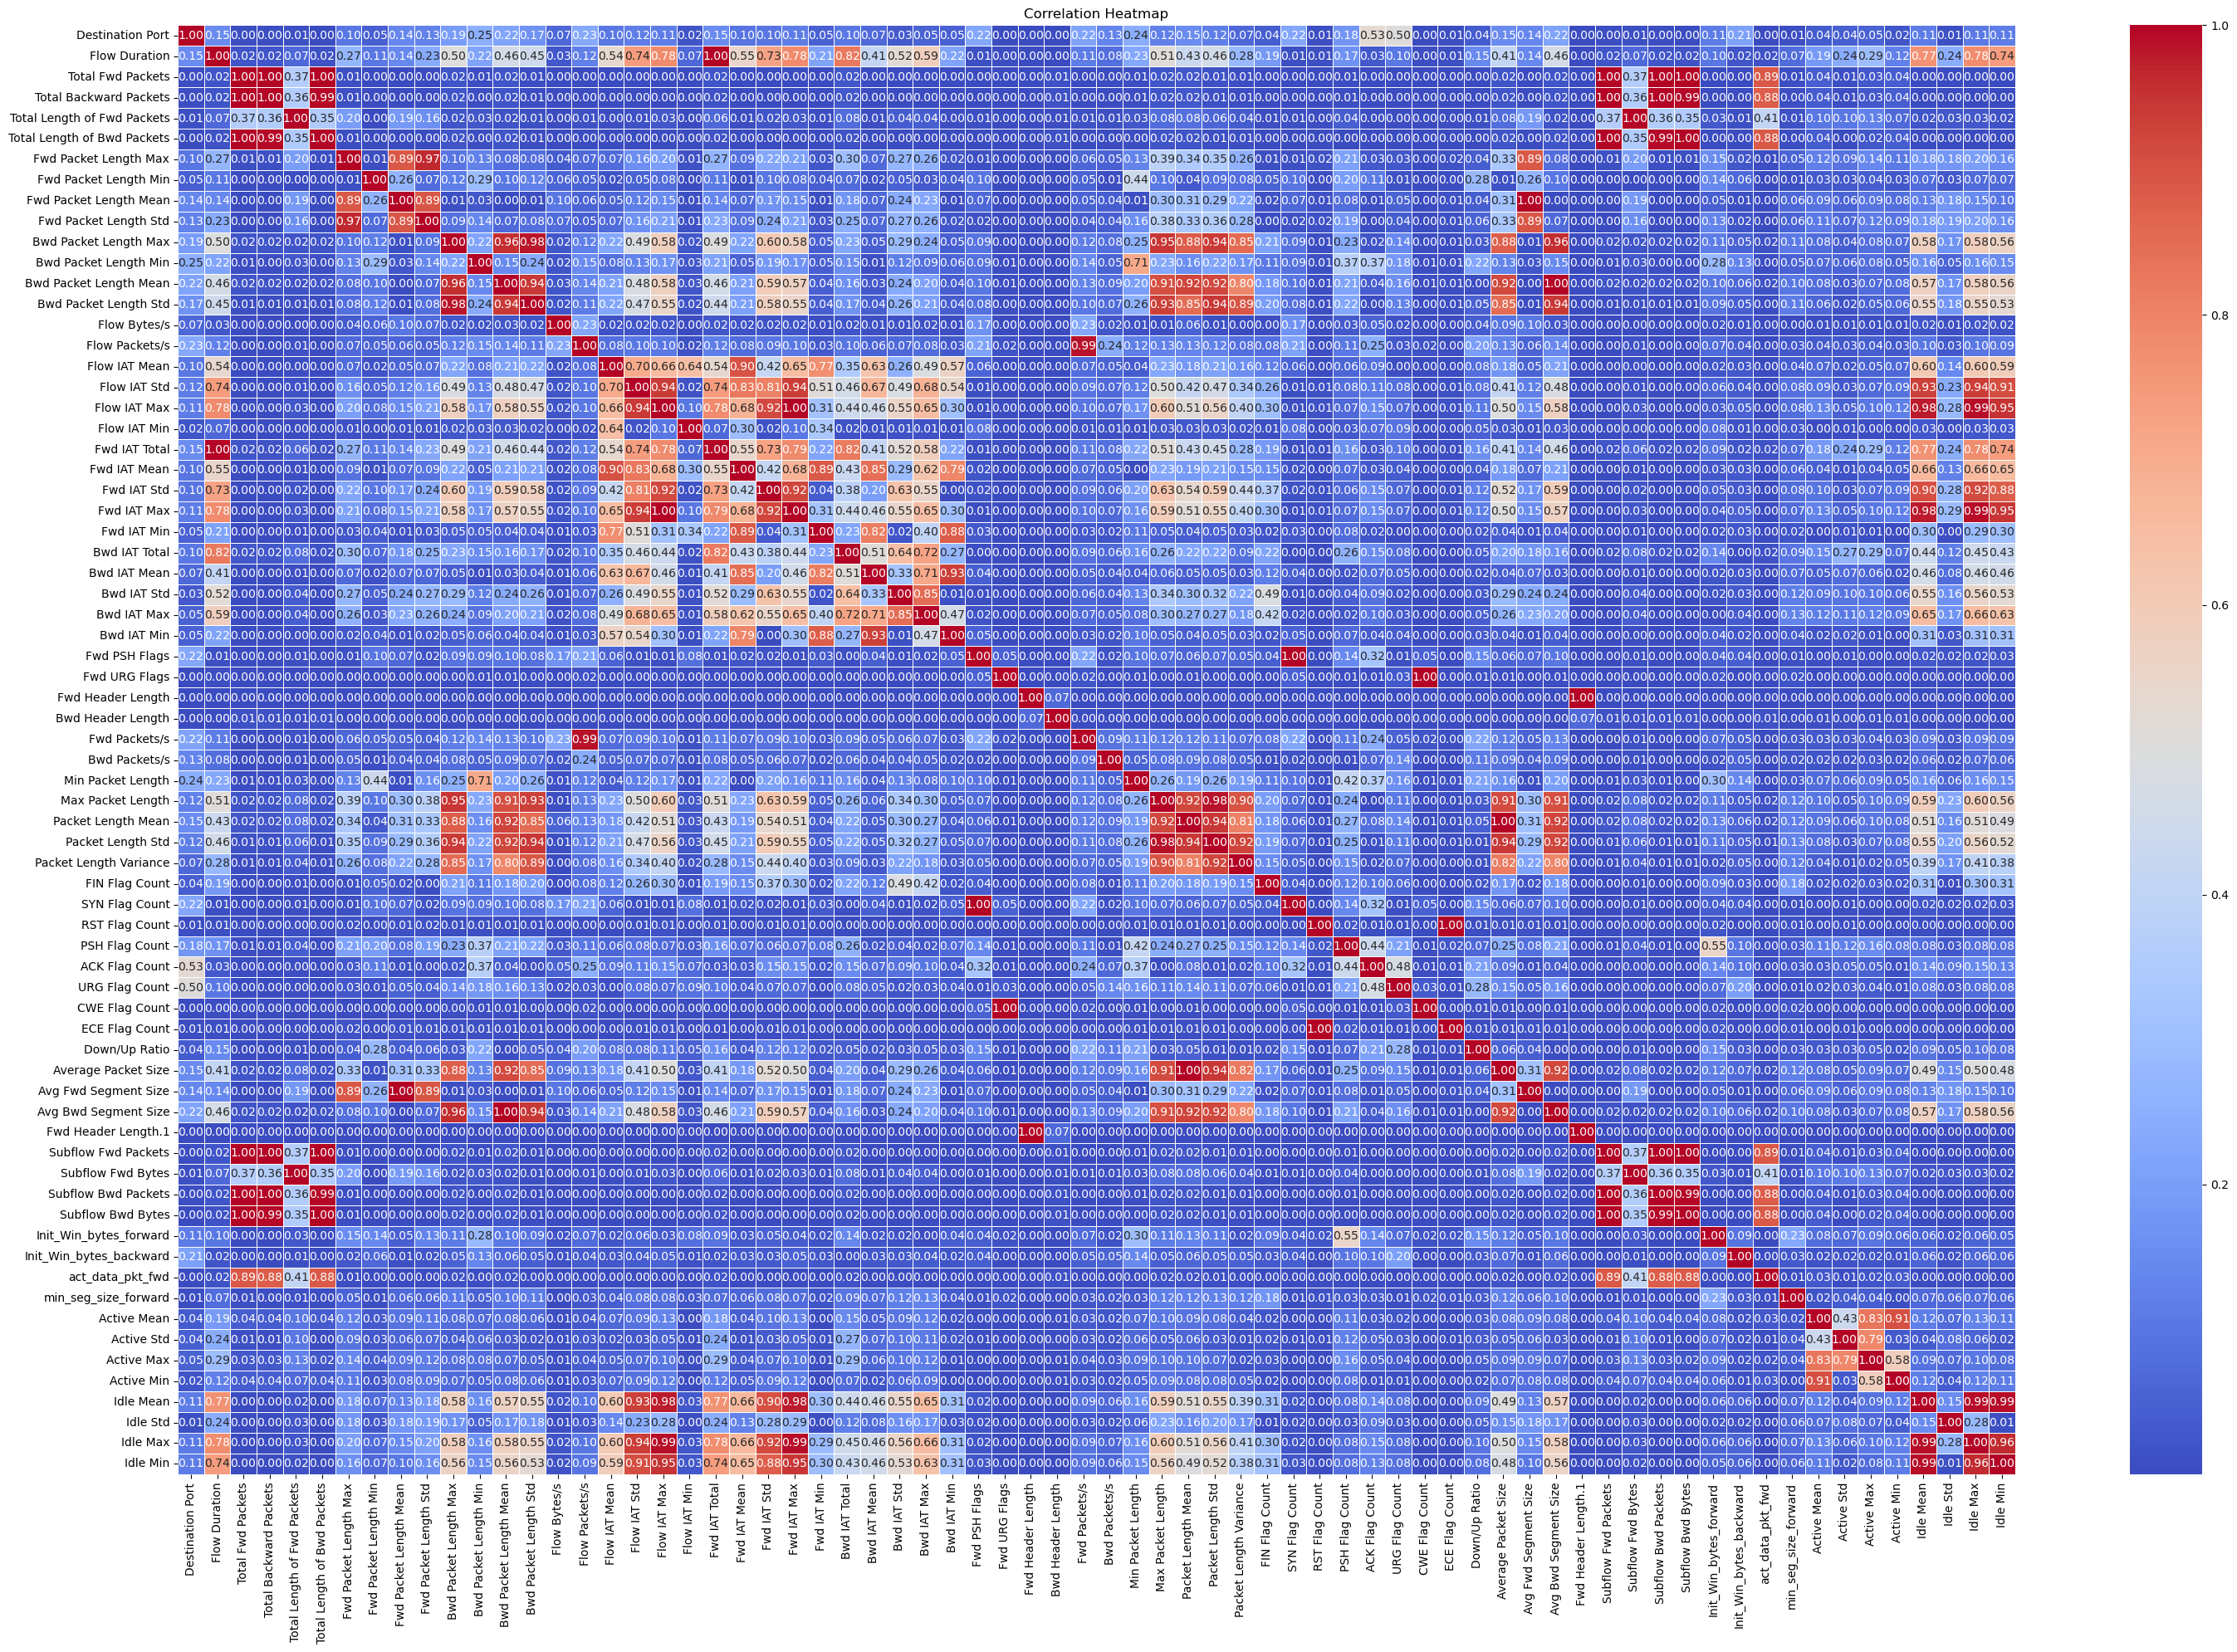

In [10]:
import seaborn as sb
import matplotlib.pyplot as plt

num_cols = sanitized_data.select_dtypes(include=[np.number]).columns
X_num = sanitized_data[num_cols]

X_num = X_num.loc[:, X_num.std() > 1e-6]
correlation_matrix = X_num.corr().abs()

plt.figure(figsize=(30,20))
sb.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

So we have a lot of intercorrelation between features, based on the heatmap here. After trying preliminary VIF analysis, it turns out that I can't quite make that work - due to the fact that some values are NaN or +/-inf so that the model can run without exploding, VIF can not properly run computations. As a result, I'll have to go with pruning high correlation values manually instead.

In [11]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

analysis_corr_matrix = sanitized_data.drop(columns=['Label']).corr().abs()
upper_tri = analysis_corr_matrix.where(np.triu(np.ones(analysis_corr_matrix.shape), k=1).astype(bool))

threshold = 0.90
high_corr_features = [column for column in upper_tri.columns if any(upper_tri[column] > threshold)]

print(f"Highly correlated features (> {threshold}):")
print(high_corr_features)


Highly correlated features (> 0.9):
['Total Backward Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Std', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow IAT Max', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Bwd IAT Min', 'Fwd Packets/s', 'Max Packet Length', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'SYN Flag Count', 'CWE Flag Count', 'ECE Flag Count', 'Average Packet Size', 'Avg Fwd Segment Size', 'Avg Bwd Segment Size', 'Fwd Header Length.1', 'Subflow Fwd Packets', 'Subflow Fwd Bytes', 'Subflow Bwd Packets', 'Subflow Bwd Bytes', 'Active Min', 'Idle Mean', 'Idle Max', 'Idle Min']


Here's a list of features with correlation values greater than 0.90, which I'm putting here because the output is really crappy at showing what's what:

- 'Total Backward Packets' 
- 'Total Length of Bwd Packets'
- 'Fwd Packet Length Std'
- 'Bwd Packet Length Mean' 
- 'Bwd Packet Length Std' 
- 'Flow IAT Max'
- 'Fwd IAT Total' 
- 'Fwd IAT Mean'
- 'Fwd IAT Std'
- 'Fwd IAT Max'
- 'Bwd IAT Min' 
- 'Fwd Packets/s'
- 'Max Packet Length'
- 'Packet Length Mean'
- 'Packet Length Std'
- 'Packet Length Variance'
- 'SYN Flag Count'
- 'CWE Flag Count'
- 'ECE Flag Count' 
- 'Average Packet Size'
- 'Avg Fwd Segment Size'
- 'Avg Bwd Segment Size'
- 'Fwd Header Length.1'
- 'Subflow Fwd Packets'
- 'Subflow Fwd Bytes'
- 'Subflow Bwd Packets'
- 'Subflow Bwd Bytes'
- 'Active Min'
- 'Idle Mean'
- 'Idle Max'
- 'Idle Min'

Upon further investigation, these are almost ALL derived features, which are redundant contribute little ot the overall dataset. I'm going to remove these and re-run the correlation analysis to check.

In [12]:
#primary_features = [' Total Backward Packets', ' SYN Flag Count', ' ECE Flag Count']
derived_features = [
'Fwd Packet Length Mean',
'Fwd Packet Length Std',
'Fwd Packet Length Min',
'Fwd Packet Length Max',
'Bwd Packet Length Mean',
'Bwd Packet Length Std',
'Bwd Packet Length Min',
'Bwd Packet Length Max',
'Packet Length Mean',
'Packet Length Std',
'Packet Length Variance',
'Max Packet Length',
'Total Length of Fwd Packets',
'Total Length of Bwd Packets',
'Average Packet Size',
'Avg Fwd Segment Size',
'Avg Bwd Segment Size',
'Flow Bytes/s',
'Flow Packets/s',
'Fwd Packets/s',
'Bwd Packets/s',
'Flow IAT Mean',
'Flow IAT Std',
'Flow IAT Min',
'Flow IAT Max',
'Fwd IAT Total',
'Fwd IAT Mean',
'Fwd IAT Std',
'Fwd IAT Min',
'Fwd IAT Max',
'Bwd IAT Total',
'Bwd IAT Mean',
'Bwd IAT Std',
'Bwd IAT Min',
'Bwd IAT Max',
'Active Mean',
'Active Std',
'Active Max',
'Active Min',
'Idle Mean',
'Idle Std',
'Idle Max',
'Idle Min',
'Subflow Fwd Packets',
'Subflow Fwd Bytes',
'Subflow Bwd Packets',
'Subflow Bwd Bytes',
'Fwd Header Length.1',
'CWE Flag Count',
'ECE Flag Count'
]

reduced_analysis_df = sanitized_data.drop(columns=derived_features, errors="ignore")
print(reduced_analysis_df.columns)
print(reduced_analysis_df.shape)

Index(['Destination Port', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Min Packet Length', 'FIN Flag Count',
       'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count',
       'URG Flag Count', 'Down/Up Ratio', 'Fwd Avg Bytes/Bulk',
       'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk',
       'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate', 'Init_Win_bytes_forward',
       'Init_Win_bytes_backward', 'act_data_pkt_fwd', 'min_seg_size_forward',
       'Label'],
      dtype='object')
(2830743, 29)


Upon attempting to do the final VIF analysis step, I was getting some issues with NaN or +/- inf values. I have made some edits to the sanitize_df function to accomodate this and drop inf and NaN values.

In [13]:
from sklearn.preprocessing import StandardScaler, RobustScaler
import statsmodels.api as sma

reduced_analysis_df = reduced_analysis_df.dropna(subset=['min_seg_size_forward'])
reduced_analysis_df_labelless = reduced_analysis_df.drop(columns=['Label'])

scaler = RobustScaler()
scaled = pd.DataFrame(scaler.fit_transform(reduced_analysis_df_labelless), columns=reduced_analysis_df_labelless.columns)

vif = sma.add_constant(scaled)
vif_df = pd.DataFrame()
vif_df["Feature"] = vif.columns
vif_df["VIF Score"] = [variance_inflation_factor(vif.values, i) for i in range(vif.shape[1])]

vif_df = vif_df[vif_df["Feature"] != "const"].sort_values("VIF Score", ascending=False)

vif_df.info()
vif_df.describe()
display(vif_df)

c:\Users\kglov\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\kglov\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


<class 'pandas.core.frame.DataFrame'>
Index: 28 entries, 13 to 24
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Feature    28 non-null     object 
 1   VIF Score  20 non-null     float64
dtypes: float64(1), object(1)
memory usage: 672.0+ bytes


,Feature,VIF Score
13,SYN Flag Count,inf
5,Fwd PSH Flags,inf
4,Total Backward Packets,3422.604743
3,Total Fwd Packets,2716.468479
10,Bwd Header Length,2636.612249
9,Fwd Header Length,2243.370937
27,act_data_pkt_fwd,4.959150
16,ACK Flag Count,4.090842
15,PSH Flag Count,3.693102
11,Min Packet Length,2.731181


Notes from VIF analysis:
    - There are definitely some columns I need to analyze, so I'll have to figure that through
    - Some NaN values include:
        - Packets/Bulk
        - Flags
        - Bulk Rate
    - These values could be useful, so keep them for now perhaps, and experiment by dropping those values later.

The highest VIF scores are stats regarding IAT among some others. That said, the aforementioned values are well above the benchmark of > 10 VIF scores.

I really want to try to run the model before doing cleaning just to see how stable the data set is already. Maybe I was making a mistake somewhere before when training the model. I would imagine the data set is already somewhat clean, but I could be wrong.

In [41]:
#print(reduced_analysis_df.shape)
#print(reduced_analysis_df['Label'])

print("X (PCA) rows:", len(reduced_analysis_df), "unique idx:", reduced_analysis_df.index.is_unique)

print("Dup keys in X:", reduced_analysis_df.index.duplicated().sum())

print("Index overlap size:", len(reduced_analysis_df.index.intersection(nonan_y.index)))


#display(vif_df)

X (PCA) rows: 2830708 unique idx: False
Dup keys in X: 2138005
Index overlap size: 692703


So even with a reduced random forest, it is still taking FOREVER to run the model fitting. It looks like PCA is not going to be an option here. I'll have to make note of how PCA and dropping features should be handled, as I don't have a choice to skip PCA anymore.

In [102]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler

# Make sure you pass in the sanitized data here!
def decompose_data(df, n_components=5, visualize=True):
    labelless_df = df.drop(columns=['Label'], errors='ignore')

    scaler = RobustScaler()
    df_scaled = scaler.fit_transform(labelless_df)

    if not np.isfinite(df_scaled).all():
        num_bad_elements = (~np.isfinite(df_scaled)).sum()
        raise ValueError(f"Non-finite values detected after scaling: {num_bad_elements} elements")
    else:
        print("Could not find non-finite elements during PCA! -Success!")
    
    integrity_check = pd.DataFrame(df_scaled)
    for col in integrity_check.columns: assert integrity_check[col].isna().sum() == 0

    pca = PCA(n_components=n_components)
    X_pca = pd.DataFrame(pca.fit_transform(df_scaled))

    X_pca = pd.DataFrame(
                    X_pca, 
                    columns=[f'PC{i+1}' for i in range(n_components)]
                )

    variance = np.cumsum(pca.explained_variance_ratio_)
    print("Explained Variance: ", variance)

    if visualize is True:
        plt.figure(figsize=(8,5))
        plt.plot(np.arange(1,len(variance)+1), variance, marker='o')
        plt.xlabel('Num components')
        plt.ylabel('Explained Variance')
        plt.title("PCA")
        plt.grid(True)
        plt.show()

    assert X_pca.shape[0].__eq__(df.shape[0])

    return X_pca

print(reduced_analysis_df.shape)
print(sanitized_data.shape)

(2830708, 29)
(2830743, 79)


Because of how messy this notebook is, and to make it easier to transfer to individual python scripts when I submit my project, I'm making a function that serves as a pipeline for the entire cleaning and pre-processing phase.

Dropped 6 zero-IQR cols before RobustScaler
(2830743, 14)
(2830743,)
                            precision    recall  f1-score   support

                    BENIGN       1.00      1.00      1.00    454620
                       Bot       0.86      0.80      0.83       393
                      DDoS       1.00      1.00      1.00     25606
             DoS GoldenEye       1.00      1.00      1.00      2059
                  DoS Hulk       1.00      1.00      1.00     46215
          DoS Slowhttptest       0.98      0.98      0.98      1100
             DoS slowloris       0.99      0.99      0.99      1159
               FTP-Patator       1.00      0.98      0.99      1588
                Heartbleed       1.00      1.00      1.00         2
              Infiltration       1.00      0.71      0.83         7
                  PortScan       0.99      1.00      1.00     31786
               SSH-Patator       1.00      1.00      1.00      1179
  Web Attack � Brute Force       0.38      0.3

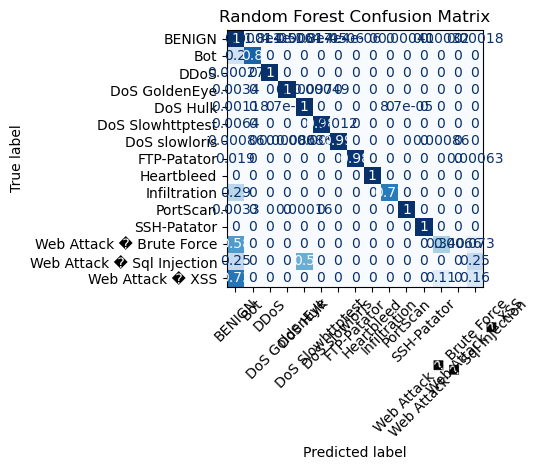

In [109]:
def process_data(raw_data, n_components=5, visualize=False):

    sanitized = create_sanitized_df(raw_data)

    derived_features = [
        'Fwd Packet Length Mean',
        'Fwd Packet Length Std',
        'Fwd Packet Length Min',
        'Fwd Packet Length Max',
        'Bwd Packet Length Mean',
        'Bwd Packet Length Std',
        'Bwd Packet Length Min',
        'Bwd Packet Length Max',
        'Packet Length Mean',
        'Packet Length Std',
        'Packet Length Variance',
        'Max Packet Length',
        'Total Length of Fwd Packets',
        'Total Length of Bwd Packets',
        'Average Packet Size',
        'Avg Fwd Segment Size',
        'Avg Bwd Segment Size',
        'Flow Bytes/s',
        'Flow Packets/s',
        'Fwd Packets/s',
        'Bwd Packets/s',
        'Flow IAT Mean',
        'Flow IAT Std',
        'Flow IAT Min',
        'Flow IAT Max',
        'Fwd IAT Total',
        'Fwd IAT Mean',
        'Fwd IAT Std',
        'Fwd IAT Min',
        'Fwd IAT Max',
        'Bwd IAT Total',
        'Bwd IAT Mean',
        'Bwd IAT Std',
        'Bwd IAT Min',
        'Bwd IAT Max',
        'Active Mean',
        'Active Std',
        'Active Max',
        'Active Min',
        'Idle Mean',
        'Idle Std',
        'Idle Max',
        'Idle Min',
        'Subflow Fwd Packets',
        'Subflow Fwd Bytes',
        'Subflow Bwd Packets',
        'Subflow Bwd Bytes',
        'Fwd Header Length.1',
        'CWE Flag Count',
        'ECE Flag Count',
    ]

    
    sanitized = sanitized.drop(columns=derived_features, errors='ignore')

    # Setting up PCA
    label = 'Label'

    nonan_y = sanitized['Label'].copy() if 'Label' in sanitized.columns else (sanitized[' Label'].copy() if ' Label' in sanitized.columns else None)
    nonan_X = sanitized.drop(columns=label).copy()

    nonan_X = nonan_X.apply(pd.to_numeric, errors='coerce').replace([np.inf, -np.inf], np.nan)

    keep_mask = nonan_X.notna().all(axis=1) & nonan_y.notna()
    nonan_X = nonan_X.loc[keep_mask].reset_index(drop=True)
    nonan_y = nonan_y.loc[keep_mask].reset_index(drop=True)

    nunique = nonan_X.nunique(dropna=True)
    const_cols = nunique[nunique <= 1].index.tolist()
    if const_cols:
        nonan_X = nonan_X.drop(columns=const_cols)

    iqr = nonan_X.quantile(0.75) - nonan_X.quantile(0.25)
    zero_iqr_cols = iqr[iqr==0].index.tolist()
    if zero_iqr_cols:
        nonan_X = nonan_X.drop(columns=zero_iqr_cols)
        print(f"Dropped {len(zero_iqr_cols)} zero-IQR cols before RobustScaler")

    assert nonan_X.shape[0] == sanitized.shape[0]
    
    X = pd.concat([nonan_X, nonan_y], axis=1)

    #for col in X.columns: assert X[col].isna().sum() == 0

    #PCA_reduced_df = decompose_data(X, n_components=n_components, visualize=visualize)
    #PCA_reduced_df = pd.concat([PCA_reduced_df, nonan_y], axis=1)

    #assert PCA_reduced_df.shape[0] == X.shape[0]
    return X
    #return PCA_reduced_df

clean_df = process_data(all_data_raw, n_components=5, visualize=False)
model = train_model(clean_df, n_estimators=30)

#print(pca_df.shape)                 # rows should match filtered X; cols = 6 (5 PCs + Label)
#print(pca_df.isna().sum())          # all PC columns should be 0 NaNs
#print(pca_df['Label'].value_counts(dropna=False).head())

In [ ]:
'''
from sklearn.impute  import SimpleImputer
import matplotlib.pyplot as plt

label = 'Label'

nonan_y = reduced_analysis_df[label] if label in reduced_analysis_df.columns else None
nonan_X = reduced_analysis_df.drop(columns=[label]) if label in reduced_analysis_df.columns else reduced_analysis_df

nonan_X = nonan_X.apply(pd.to_numeric, errors='coerce')
nonan_X = nonan_X.replace([np.inf, -np.inf], np.nan)

#if mode == 'drop':
keep_mask = ~nonan_X.isna().any(axis=1)
nonan_X = nonan_X.loc[keep_mask]
nonan_y = nonan_y.loc[keep_mask]
nonan_y = nonan_y.loc[nonan_y.notna()]
X_clean = nonan_X.to_numpy(dtype=np.float64, copy=False)


print(X_clean.shape)
#else:

X_clean_df = pd.DataFrame(X_clean, index=nonan_X.index, columns=nonan_X.columns)

PCA_reduced_df = decompose_data(X_clean_df, visualize=False)
#print(PCA_reduced_df.shape)
#print(nonan_y.shape)
PCA_reduced_df_labels = PCA_reduced_df.join(nonan_y)
#print(PCA_reduced_df_labels.shape)
'''

(2830708, 28)
Explained Variance:  [0.94484916 0.98989872 0.99612358 0.99924582 0.99955363]


*So something that I didn't know was a thing, was something called "many-to-many joining" when it comes to DataFrame.join(). This is an issue here given that I have 2 million data points, which constitutes to enough for me to have this issue. What this effectively means is this: when I attempt to join the dataframes for the labels and PCA processed data, they combine in such a way that massively explodes the dataset, and breaks everything. What I need to do now is take the raw data and process it into the data I need based on the preprocessing steps I have taken thus far.*

Okay, so NEW issue: I don't have enough physical memory to run PCA! I might be able to get away with running less cells so I have less data and variables to keep track of, but I'm concerned I might not have the physical resources to handle model training, or at least the PCA DR. I might need to look into getting time on that supercomputer at SJSU to help with processing the data here, but I need to figure that out and may even need to get a word from Prof Rayes or Flores for this. Either way, I need to do some investigating it seems.

I managed to get the freatures cleaned and stripped down to what they need to be for training. Now, let's see if this bed rocks!


In [110]:
#from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

def train_model(input_df, test_size=0.2, random_state=42, n_estimators=100):
        X = input_df.drop(columns=['Label'])
        y = input_df['Label'].astype(str)

        print(X.shape)
        print(y.shape)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, 
                                                            random_state=random_state, stratify=y)

        random_forest = RandomForestClassifier(n_estimators=n_estimators, random_state=random_state)
        random_forest.fit(X_train, y_train)
        forest_pred = random_forest.predict(X_test)
        forest_pred_train = random_forest.predict(X_train)
        
        report = classification_report(y_test, forest_pred, zero_division=0)
        print(report)

        train_report = classification_report(y_train, forest_pred_train, zero_division=0)
        print(train_report)

        cm = confusion_matrix(y_test, forest_pred, labels=sorted(y.unique()), normalize='true')
        display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(y.unique()))

        plt.Figure(figsize=(200,160))
        display.plot(cmap='Blues', xticks_rotation=45, colorbar=False)
        plt.title("Random Forest Confusion Matrix")
        plt.tight_layout()
        plt.show()

        results = pd.DataFrame([{
                "Model": "Random Forest",
                "Report": report,
                "Predictions": forest_pred
        }])

        return results